# **Methylation Analysis of Bisulfite Treated GRBV Amplicons following Sanger Sequencing** 
#### The following script summarizes the total number of CpG islands and alternative methylation sites from a given fasta files (reference genome). Following this survey, an additional fasta file must be provided, where the methylated cytosines of the reference genome have been substituted with 'M' (methylated genome). By providing this second input, the program produces the total number of genome methylations, the percentage of methylation and the distribution of methylation across different methylaiton sites. This could be implemented by providing genomic features as CDS or gene regions with a third input, in order to analyze any differences between genomic regions or genes in methyation patterns. 

### **1. Set up the working environment**
#### In this code block, the program checks for the conda version and import/install the packages needed for the downstream operations.

##### This first command asks conda to check for updates for its package manager in the "defaults" channel and, if needed, to install the latest version available.

In [1]:
conda update -n base -c defaults conda

Solving environment: done

## Package Plan ##

  environment location: /Applications/anaconda3

  added / updated specs:
    - conda


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    beautifulsoup4-4.12.2      |  py310hecd8cb5_0         218 KB
    boltons-23.0.0             |  py310hecd8cb5_0         426 KB
    certifi-2023.5.7           |  py310hecd8cb5_0         153 KB
    conda-23.5.2               |  py310hecd8cb5_0         1.0 MB
    conda-repo-cli-1.0.41      |  py310hecd8cb5_0         124 KB
    cryptography-39.0.1        |  py310hf6deb26_2         1.1 MB
    jsonpatch-1.32             |     pyhd3eb1b0_0          15 KB
    jsonpointer-2.1            |     pyhd3eb1b0_0           9 KB
    jupyter_core-5.3.0         |  py310hecd8cb5_0          91 KB
    ldid-2.1.5                 |       hc58f1be_3          64 KB
    libarchive-3.6.2           |       h29ab7a1_2         782 KB
    li

##### Install packages using pip install

In [2]:
%%sh
pip install gffutils # https://pythonhosted.org/pyfaidx/
pip install pyfaidx # https://pythonhosted.org/gffutils/contents.html
pip install biopython # https://biopython.org
pip install matplotlib # https://matplotlib.org
pip install pandas # https://pandas.pydata.org

  Using cached gffutils-0.12-py3-none-any.whl (1.6 MB)
  Using cached pyfaidx-0.7.2.1-py3-none-any.whl (28 kB)
  Using cached argh-0.28.1-py3-none-any.whl (40 kB)
  Using cached argcomplete-3.1.1-py3-none-any.whl (41 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.5/75.5 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 9.5 MB/s eta 0:00:001
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.5/243.5 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 11

### **2. Counting Cs from the Reference Genome**
#### In this second code block, the program uses biopython for parsing the fasta file and counting the total number of cytosines.

In [3]:
#Import biopython module
from Bio import SeqIO

#Define a function for reading through the sequence and count the Cs
def total_c(your_fasta_file):
    count = 0
    length = 0
    for record in SeqIO.parse(your_fasta_file, "fasta"):
        seq = str(record.seq)
        count += seq.count('C')
        length += len(seq)
    c_per = (count / length) * 100

    return count, length, c_per

#Apply the function
fasta_file = 'GRBV.fasta'
total_c_in_seq = (total_c(fasta_file)[0])
C_percentage = str(round((total_c(fasta_file)[2]), 2))
genome_length = str(total_c(fasta_file)[1])
print(f"Number of 'C' in the input genome: {total_c_in_seq}\nThis represents the {C_percentage}% of the GRBV genome ({genome_length} bp)!")

Number of 'C' in the input genome: 511
This represents the 15.94% of the GRBV genome (3206 bp)!


### **3. CpG Islands and Methylation Sites Survey on the Reference Genome**
#### This code provides a summary about the total number of methylation sites present in the reference genome, as well as the count of each different type of methylation site. For CHG and CHH, H represents C, T or A, and in the case of CHH, the two Hs can be different bases (CTA) or equal (CAA) as well. The code also outputs a data frame (df_initial) containing information about the type of methylation site and its genomic position. The genomic position is 1-based and it indicates the genomic position of the cytosine (i.e. ATTAGAG**CG**TAGTATTA, CG in position 8).

In [4]:
#Import packages and modules
import pandas as pd
import re

#Here I'm creating the function for collecting the data about CpG island for a given genome in fasta format
def cpg_counter(fasta_file):
    total = 0
    cpg = 0
    chg = 0
    chh = 0
    cpg_islands = []
    pattern = re.compile(r'CG|C[ACT]G|C[ACT][ACT]')

    for record in SeqIO.parse(fasta_file, "fasta"):
        seq = str(record.seq)
        matches = pattern.finditer(seq)
        for match in matches:
            total += 1
            if match.group() == 'CG':
                cpg += 1
                island_type = 'CpG'
            elif match.group() == 'CAG' or match.group() == 'CTG' or match.group() == 'CCG':
                chg += 1
                island_type = 'CHG'
            elif len(match.group()) == 3:
                chh += 1
                island_type = 'CHH'
            #Here, the +1 enable us to convert the output coordinates from 0-based to 1-based
            start = match.start() + 1
            end = match.end()
            cpg_islands.append((island_type, start, end))

    return total, cpg, chg, chh, cpg_islands

#Here I'm applying our new the function
file = 'GRBV.fasta'
total, cpg, chg, chh, cpg_islands = cpg_counter(file)

#Now I can create a data frame containing our CpG islands data
df_initial = pd.DataFrame(cpg_islands, columns=['Type', 'Start', 'End'])
output = 'cpg_islands.csv'
df_initial.to_csv(output, index=False)
#Here we print our new data frame
print(df_initial)
print()

#And now we print the counts
print(f"Total number of CpG islands in the FASTA file: {total}")
print(f"Number of CpG islands (CpG): {cpg}")
print(f"Number of CpG islands (CHG): {chg}")
print(f"Number of CpG islands (CHH): {chh}")

    Type  Start   End
0    CHG      2     4
1    CHH      6     8
2    CHH     11    13
3    CpG     20    21
4    CHH     29    31
..   ...    ...   ...
395  CHH   3139  3141
396  CHH   3143  3145
397  CHH   3169  3171
398  CHH   3176  3178
399  CHH   3195  3197

[400 rows x 3 columns]

Total number of CpG islands in the FASTA file: 400
Number of CpG islands (CpG): 105
Number of CpG islands (CHG): 78
Number of CpG islands (CHH): 217


### **4. Import and Check the Second Input Fasta File**
#### The second fasta file that is used as input, is the one that contains the reference genome with C-to-M substitutions in the case of a methylated C. Since this framework is dedicated to Sanger BS Amplicon sequencing which involves short amplicons (~150-400 bp), the C-to-M substitution will be achieved by and while annotating the methylations on the reference genome by the user (for now).

In [5]:
#Assign our second fasta or text file to the variable file
file = '24dpi_GRBV_M.txt' 

#Parse the file in read settings
with open(file, 'r') as file:
    content = file.read()
#Count the number of M
positions = [i + 1 for i, char in enumerate(content) if char == 'M']

#Create data frame with the position of each detected M or methylation in our file
data = {'Position': positions, 'Letter': 'M'}
df_M_position = pd.DataFrame(data)
df_initial = df_initial.rename(columns={'Start': 'Position'})

print(df_M_position)
print(df_initial)

    Position Letter
0          6      M
1          8      M
2         12      M
3         29      M
4         33      M
..       ...    ...
87      2983      M
88      2985      M
89      3016      M
90      3031      M
91      3034      M

[92 rows x 2 columns]
    Type  Position   End
0    CHG         2     4
1    CHH         6     8
2    CHH        11    13
3    CpG        20    21
4    CHH        29    31
..   ...       ...   ...
395  CHH      3139  3141
396  CHH      3143  3145
397  CHH      3169  3171
398  CHH      3176  3178
399  CHH      3195  3197

[400 rows x 3 columns]


### **5. Absolute Methylation Analysis over Input Genomic Features**

#### Now, the program merges the two data frames we created so far: df_initial, which contains information about genomic methylation sites potision and their types, and df_M_position, which contains the genomic coordinates of the methylation the user detected through sanger BS amplicon sequencing. The combined data frame (df) will contain the position and the type of each methylated site in our experiment.

In [6]:
#Merge the two
final_df = pd.merge(df_initial, df_M_position, on='Position')
df = final_df.drop('Letter', axis=1)
df = df.drop('End', axis=1)

df.head()

,Type,Position
0,CHH,6
1,CHH,29
2,CpG,33
3,CHH,38
4,CpG,102


##### Now, the code cell below provides an usage example with genomic features of GRBV NY358 genome named hotspots. Alternatively, an user can input his own genomic features name and coordinates.

In [7]:
#Here I'm creating a dictionary with the data for each column
data = {'Name': ['Hotspot 1', 'Hotspot 2', 'Hotspot 3', 'Hotspot 4', 'Hotspot 5', 'Hotspot 6', 'Hotspot 7', 'Hotspot 8', 'Hotspot 9'],
        'Start': [222, 377, 552, 732, 871, 1496, 1651, 2631, 2952],
        'End': [369, 536, 721, 851, 1201, 1636, 1751, 2831, 3051]}

#Dictionary to dataframe
features = pd.DataFrame(data)

features

,Name,Start,End
0,Hotspot 1,222,369
1,Hotspot 2,377,536
2,Hotspot 3,552,721
3,Hotspot 4,732,851
4,Hotspot 5,871,1201
5,Hotspot 6,1496,1636
6,Hotspot 7,1651,1751
7,Hotspot 8,2631,2831
8,Hotspot 9,2952,3051


In [8]:
#Create an empty data frame to store the results from this code cell, with three columns named type, position, name
df_result = pd.DataFrame(columns=['Type', 'Position', 'Name'])

#Iterate over each row in our data frame (df) containing the position and type of sites of the methylations
for index, row in df.iterrows():
    position = row['Position']
    
    #Iterate over each row in the features data frame to use the coordinates to assign our methylations from df to the features contained in the features data frame
    for index2, row2 in features.iterrows():
        start = row2['Start']
        end = row2['End']
        
        #If loop to check if the given position falls within the range provided with the genomic features
        if start <= position <= end:
            #Create a new temporary data frame with the Type (methylation site), Position, and Name (of the feature)
            temp_df = pd.DataFrame({'Type': [row['Type']],
                                    'Position': [row['Position']],
                                    'Name': [row2['Name']]})
            
            #Concatenate the temporary data frame with df_result
            df_result = pd.concat([df_result, temp_df], ignore_index=True)
            break  #Break out of the inner loop we created once we find a match

print(df_result)

   Type Position       Name
0   CHH      410  Hotspot 2
1   CHG      425  Hotspot 2
2   CHG      458  Hotspot 2
3   CHH      464  Hotspot 2
4   CHH      475  Hotspot 2
5   CHG      486  Hotspot 2
6   CHH      494  Hotspot 2
7   CpG      497  Hotspot 2
8   CpG      512  Hotspot 2
9   CHH      662  Hotspot 3
10  CHH      666  Hotspot 3
11  CpG      762  Hotspot 4
12  CHG      780  Hotspot 4
13  CpG      788  Hotspot 4
14  CpG      791  Hotspot 4
15  CHH      800  Hotspot 4
16  CHH      956  Hotspot 5
17  CHH      967  Hotspot 5
18  CHH      986  Hotspot 5
19  CHH     1022  Hotspot 5
20  CHH     1037  Hotspot 5
21  CHG     1047  Hotspot 5
22  CHH     1057  Hotspot 5
23  CpG     1075  Hotspot 5
24  CHH     1092  Hotspot 5
25  CpG     1098  Hotspot 5
26  CpG     1115  Hotspot 5
27  CpG     1127  Hotspot 5
28  CHG     1172  Hotspot 5
29  CHH     1187  Hotspot 5
30  CHH     1194  Hotspot 5
31  CHH     1564  Hotspot 6
32  CHH     1570  Hotspot 6
33  CHH     1574  Hotspot 6
34  CpG     1605  Ho

##### Now we can start building some graph to summarize our methylation analysis

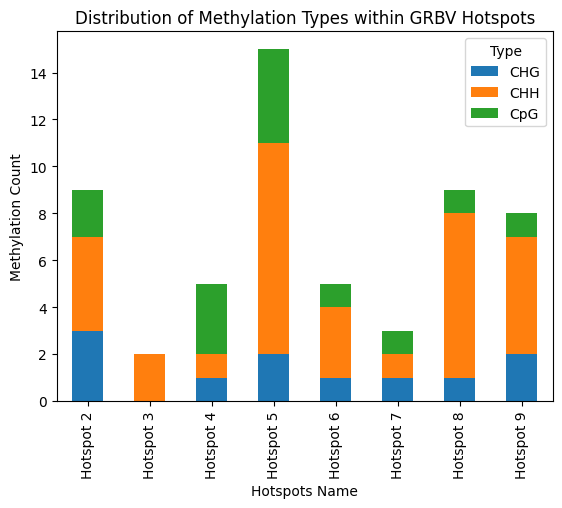

In [9]:
import matplotlib.pyplot as plt

#This code groups our data by Name and Type and get their count from df_result
grouped = df_result.groupby(['Name', 'Type']).size().reset_index(name='Count')

#Produce a pivot table to get Type as columns and Name as index
pivot_table = grouped.pivot(index='Name', columns='Type', values='Count').fillna(0)

#Plot the graph
pivot_table.plot(kind='bar', stacked=True)
plt.xlabel('Hotspots Name')
plt.ylabel('Methylation Count')
plt.title('Distribution of Methylation Types within GRBV Hotspots')
plt.legend(title='Type')
plt.show()

##### The same operation can be performed with other genomic features. In this case we are dividing the genome into structural and non-structural genes, and intergenic regions.

In [10]:
#Here I'm creating a dictionary with the data for each column
data2 = {'Name': ['Structural', 'Non Structural', 'LIR', 'SIR'],
        'Start': [517, 1898, 1, 1738],
        'End': [1737, 3045, 292, 1898]}

#Dictionary to dataframe
features2 = pd.DataFrame(data2)

features2

,Name,Start,End
0,Structural,517,1737
1,Non Structural,1898,3045
2,LIR,1,292
3,SIR,1738,1898


In [11]:
#As before, create an empty data frame to store the results
df_result2 = pd.DataFrame(columns=['Type', 'Position', 'Name'])

#Now iterate over each row in df...
for index, row in df.iterrows():
    position = row['Position']
    
    #...and over each row in features2
    for index2, row2 in features2.iterrows():
        start = row2['Start']
        end = row2['End']
        
        #Position-to-range mapping
        if start <= position <= end:
            #New temporary data frame
            temp_df2 = pd.DataFrame({'Type': [row['Type']],
                                    'Position': [row['Position']],
                                    'Name': [row2['Name']]})
            
            #Concatenation and results data frame
            df_result2 = pd.concat([df_result2, temp_df2], ignore_index=True)
            break

print(df_result2)

   Type Position            Name
0   CHH        6             LIR
1   CHH       29             LIR
2   CpG       33             LIR
3   CHH       38             LIR
4   CpG      102             LIR
..  ...      ...             ...
62  CHG     2978  Non Structural
63  CHH     2983  Non Structural
64  CpG     3016  Non Structural
65  CHH     3031  Non Structural
66  CHH     3034  Non Structural

[67 rows x 3 columns]


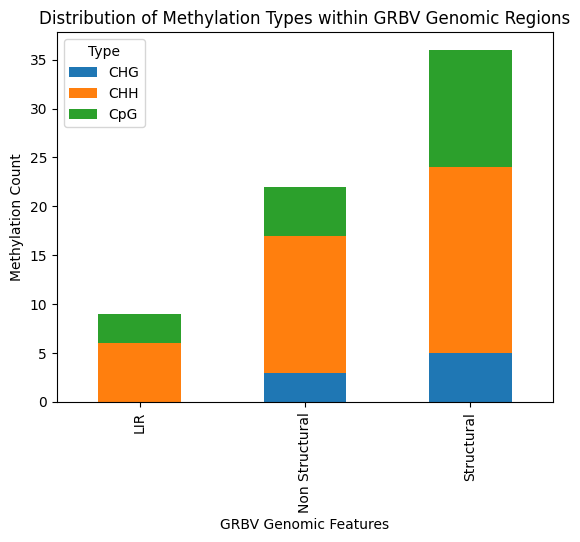

In [12]:
#This code groups our data by Name and Type and get their count from df_result
grouped2 = df_result2.groupby(['Name', 'Type']).size().reset_index(name='Count')

# Pivot table x indexing step
pivot_table2 = grouped2.pivot(index='Name', columns='Type', values='Count').fillna(0)

#Graph plotting
pivot_table2.plot(kind='bar', stacked=True)
plt.xlabel('GRBV Genomic Features')
plt.ylabel('Methylation Count')
plt.title('Distribution of Methylation Types within GRBV Genomic Regions')
plt.legend(title='Type')
plt.show()

### **6. Normalization and Analysis of Relative Methylation over Input Genomic Features**

In [13]:
#Here, the reference genome needs to be parsed to extract some information for normalization purposes
def cpg_counter(fasta_file):
    total = 0
    cpg = 0
    chg = 0
    chh = 0
    cpg_islands = []
    pattern = re.compile(r'CG|C[ACT]G|C[ACT][ACT]')

    for record in SeqIO.parse(fasta_file, "fasta"):
        seq = str(record.seq)
        matches = pattern.finditer(seq)
        for match in matches:
            total += 1
            if match.group() == 'CG':
                cpg += 1
                island_type = 'CpG'
            elif match.group() == 'CAG' or match.group() == 'CTG' or match.group() == 'CCG':
                chg += 1
                island_type = 'CHG'
            elif len(match.group()) == 3:
                chh += 1
                island_type = 'CHH'
            #Here, the +1 enables us to convert the output coordinates from 0-based to 1-based
            start = match.start() + 1
            end = match.end()
            cpg_islands.append((island_type, start, end))

    return total, cpg, chg, chh, cpg_islands

#Iterate over each row in features data frame
for index, row in features.iterrows():
    start = row['Start']
    end = row['End']
    fasta_file = "GRBV.fasta"  #Here you should replace the file name with the actual path to your fasta file
    total, cpg, chg, chh, cpg_islands = cpg_counter(fasta_file) #fasta_file is how we called the reference genome in the first code cell
    
    #Count the CpG islands within the specified genomic coordinates
    count = sum(1 for island in cpg_islands if island[1] >= start and island[2] <= end)
    CHH = sum(1 for island in cpg_islands if island[0] == 'CHH' and island[1] >= start and island[2] <= end)
    CHG = sum(1 for island in cpg_islands if island[0] == 'CHG' and island[1] >= start and island[2] <= end)
    CpG = sum(1 for island in cpg_islands if island[0] == 'CpG' and island[1] >= start and island[2] <= end)
    
    #Add the counts to new columns in features data frame
    features.loc[index, 'CpG_Count'] = count
    features.loc[index, 'CpG'] = CpG
    features.loc[index, 'CHG'] = CHG
    features.loc[index, 'CHH'] = CHH

print(features.head())

        Name  Start   End  CpG_Count   CpG   CHG   CHH
0  Hotspot 1    222   369       21.0   7.0   2.0  12.0
1  Hotspot 2    377   536       18.0   5.0   6.0   7.0
2  Hotspot 3    552   721       19.0   5.0   7.0   7.0
3  Hotspot 4    732   851       19.0   6.0   6.0   7.0
4  Hotspot 5    871  1201       43.0  13.0  13.0  17.0


#### Now we can analyze how the methylation are distributed over types of methylation site for each hotspot

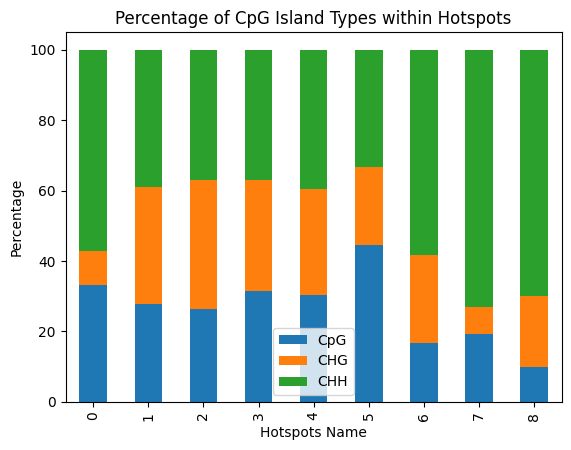

In [14]:
#Normalization Step and analysis of relative distribution of methylation site types over the provided genomic features
df_norm = features

df_norm['CpG_Percentage'] = df_norm['CpG'] / df_norm['CpG_Count'] * 100
df_norm['CHG_Percentage'] = df_norm['CHG'] / df_norm['CpG_Count'] * 100
df_norm['CHH_Percentage'] = df_norm['CHH'] / df_norm['CpG_Count'] * 100

#Plot
df_norm[['CpG_Percentage', 'CHG_Percentage', 'CHH_Percentage']].plot(kind='bar', stacked=True)
plt.xlabel('Hotspots Name')
plt.ylabel('Percentage')
plt.title('Percentage of CpG Island Types within Hotspots')
plt.legend(['CpG', 'CHG', 'CHH'])
plt.show()

#### Now we can survey the distribution of methylation sites over each hotspots. The percentage of methylation sites and their type is normalized to the total number of methylation sites of the GRBV genome

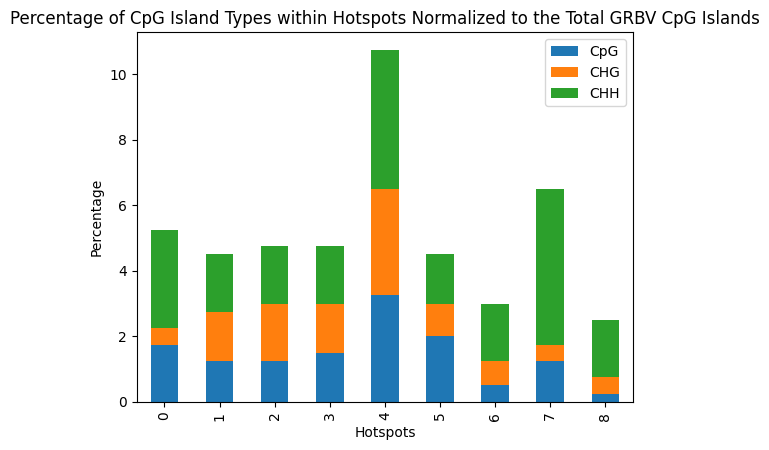

In [15]:
#Normalization Step
df_norm2 = features

df_norm2['CpG_Percentage'] = (df_norm2['CpG'] / 400) * 100
df_norm2['CHG_Percentage'] = (df_norm2['CHG'] / 400) * 100
df_norm2['CHH_Percentage'] = (df_norm2['CHH'] / 400) * 100

#Plot
df_norm2[['CpG_Percentage', 'CHG_Percentage', 'CHH_Percentage']].plot(kind='bar', stacked=True)
plt.xlabel('Hotspots')
plt.ylabel('Percentage')
plt.title('Percentage of CpG Island Types within Hotspots Normalized to the Total GRBV CpG Islands')
plt.legend(['CpG', 'CHG', 'CHH'])
plt.savefig('normalized_cpg_island_distribution_graph.png')
plt.show()

#### Now we can use the data from df_result (position, site type and genomic feature for each methylation) for creating a final histogram with methylation percentage for each hotspot, normalized to the total number of methylation sites of the reference genome.

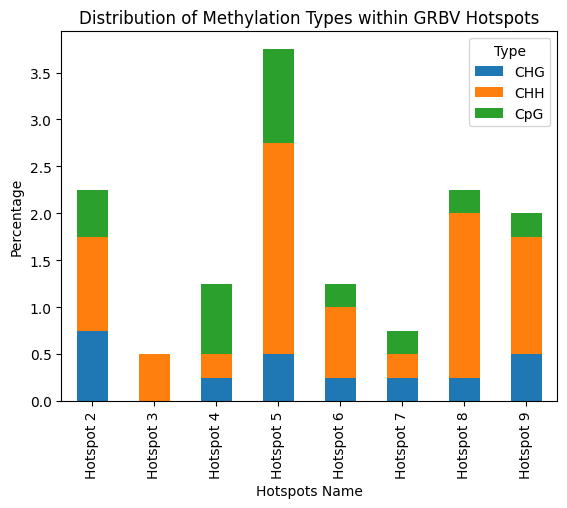

   Type Position       Name
0   CHH      410  Hotspot 2
1   CHG      425  Hotspot 2
2   CHG      458  Hotspot 2
3   CHH      464  Hotspot 2
4   CHH      475  Hotspot 2
5   CHG      486  Hotspot 2
6   CHH      494  Hotspot 2
7   CpG      497  Hotspot 2
8   CpG      512  Hotspot 2
9   CHH      662  Hotspot 3
10  CHH      666  Hotspot 3
11  CpG      762  Hotspot 4
12  CHG      780  Hotspot 4
13  CpG      788  Hotspot 4
14  CpG      791  Hotspot 4
15  CHH      800  Hotspot 4
16  CHH      956  Hotspot 5
17  CHH      967  Hotspot 5
18  CHH      986  Hotspot 5
19  CHH     1022  Hotspot 5
20  CHH     1037  Hotspot 5
21  CHG     1047  Hotspot 5
22  CHH     1057  Hotspot 5
23  CpG     1075  Hotspot 5
24  CHH     1092  Hotspot 5
25  CpG     1098  Hotspot 5
26  CpG     1115  Hotspot 5
27  CpG     1127  Hotspot 5
28  CHG     1172  Hotspot 5
29  CHH     1187  Hotspot 5
30  CHH     1194  Hotspot 5
31  CHH     1564  Hotspot 6
32  CHH     1570  Hotspot 6
33  CHH     1574  Hotspot 6
34  CpG     1605  Ho

In [16]:
#Group the data by Name and Type and get their count
grouped = df_result.groupby(['Name', 'Type']).size().reset_index(name='Count')
#By calling the groupby method, we are grouping our data by two columns ('Name' and 'Type')
#We are then calculating the count for each combination of 'Name' and 'Type'
#Lastly, the results are stored in the data frame we called "grouped"

pivot_table = grouped.pivot(index='Name', columns='Type', values='Count').fillna(0)

#Normalize the count by dividing it by 400 and multiplying it by 100 to get the percentage
pivot_table = pivot_table.div(400) * 100

#Plot the graph
pivot_table.plot(kind='bar', stacked=True)
plt.xlabel('Hotspots Name')
plt.ylabel('Percentage')
plt.title('Distribution of Methylation Types within GRBV Hotspots')
plt.legend(title='Type')
plt.savefig('normalized_methylation_distribution_graph.png')
plt.show()

print(df_result)

*Notebook Created By: Christian Mandelli, Oregon State University*